## import all necessary packages for my code to be implemented

In [1]:
import firebase_admin
from firebase_admin import credentials, db
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os
from dotenv import load_dotenv

## Initialize my own database

In [2]:
# read the variable from .env
load_dotenv()
cred_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")

if cred_path is None:
    raise ValueError("GOOGLE_APPLICATION_CREDENTIALS environment variable is not set!")

# initialize my own firebase
cred = credentials.Certificate(cred_path)
firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://csci526playertrack-default-rtdb.firebaseio.com/'
})

# fetch my own data
ref = db.reference('/')
data = ref.get()
# print("My current data collected from firebase is: ", data)

# It is time to analyze my data. Before doing so, it is necessary to convert them into the list 
# for further analysis

# results = {}
player_collection = data['players']

## The first part is used to find out the distribution of the number of times played by users

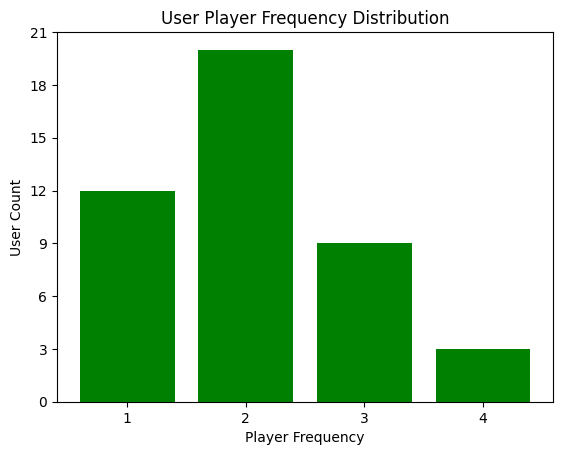

In [3]:
user_times_records = {}
for player_comb in player_collection:
    if player_comb is not None:
        currplayTimes = player_comb['totalPlays']

        if currplayTimes not in user_times_records:
            user_times_records[currplayTimes] = 0
        
        user_times_records[currplayTimes] += 1

user_times_records_sorted = sorted(user_times_records.items(), key = lambda x: x[0])
play_times_records = [int(times[0]) for times in user_times_records_sorted]
user_number_records = [int(times[1]) for times in user_times_records_sorted]

# A bar chart can be drawn, where the x-axis represents the number of times played
# and the y-axis represents the exact number of users 
plt.bar(play_times_records, user_number_records, color='green')
plt.title("User Player Frequency Distribution")
plt.xlabel("Player Frequency")
plt.ylabel("User Count")

ax = plt.gca()
ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.show()

# The second analysis is used for detecting whether a player cheats during the gameplay, especially those with one trial
# because those players are more likely to receive assistance from someone who is an expert in the game. [Later Need to Be Modified With Different Levels]

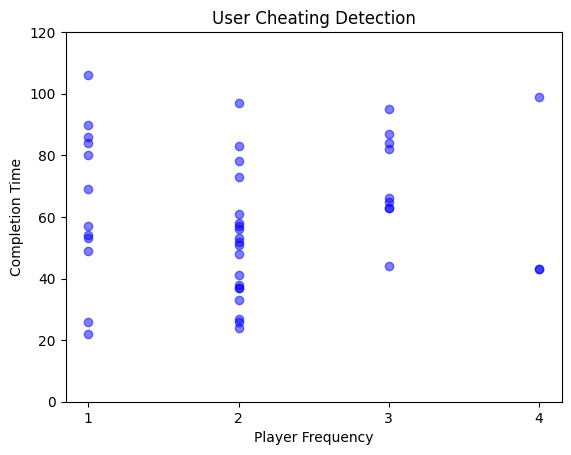

In [4]:
detect_cheating_records = []
detect_uncheating_records = []
for player_comb in player_collection:
    curr_res = []
    if player_comb is not None:
      currplayTimes = player_comb['totalPlays'] # calculate the total number of times who played the game
      game_record_size = len(player_comb['records'])
      completion_time = player_comb['records'][game_record_size - 1]['timeOrReason']
      completion_time_int = int(completion_time[:completion_time.find('s')])
      
      curr_res.append(currplayTimes)
      curr_res.append(completion_time_int)
      
      if currplayTimes == 1:
        if completion_time_int < 10:
            # The player is cheated during the game
            detect_cheating_records.append(curr_res)
        else:
            # The player is not cheated during the game
            detect_uncheating_records.append(curr_res)
      else:
        average_failed_time = 120 / (currplayTimes - 1)
        if completion_time_int < 0.2 * average_failed_time:
            # The player is cheated during the game
            # equation: the time for completion is less tahn 20% of the average oe the failed attempts
            detect_cheating_records.append(curr_res)
        else:
            # The player is not cheated during the game
            detect_uncheating_records.append(curr_res)

# For both dictionaries called detect_cheating_records and detect_uncheating_records, the output can be identified as below
# [[number of times(1), time(1)], [number of times(2), time(2)], [number of times(3), time(3)], ...]

detect_cheating_times = [cheat[0] for cheat in detect_cheating_records]
detect_cheating_specific_time = [cheat[1] for cheat in detect_cheating_records]
detect_uncheating_times = [uncheat[0] for uncheat in detect_uncheating_records]
detect_uncheating_specific_time = [uncheat[1] for uncheat in detect_uncheating_records]
# print("The number of times associated with cheating players are: ", detect_cheating_times)
# print("The completion time associated with cheating players are: ", detect_cheating_specific_time)

# Last but not least, a scatter can be drawn, attempting to illustrate the relationship between the number of times played and the completion time
plt.scatter(detect_cheating_times, detect_cheating_specific_time, color='red', alpha=0.5)
plt.scatter(detect_uncheating_times, detect_uncheating_specific_time, color='blue', alpha=0.5)
plt.title("User Cheating Detection")
plt.xlabel("Player Frequency")
plt.ylabel("Completion Time")
plt.ylim(0, 120)
plt.xticks(range(1, 5))
plt.show()  

# The third metric is used for retrieving the distribution of the number of times played by users
# with respect to the completion time [Later Need to Be Modified With Different Levels]

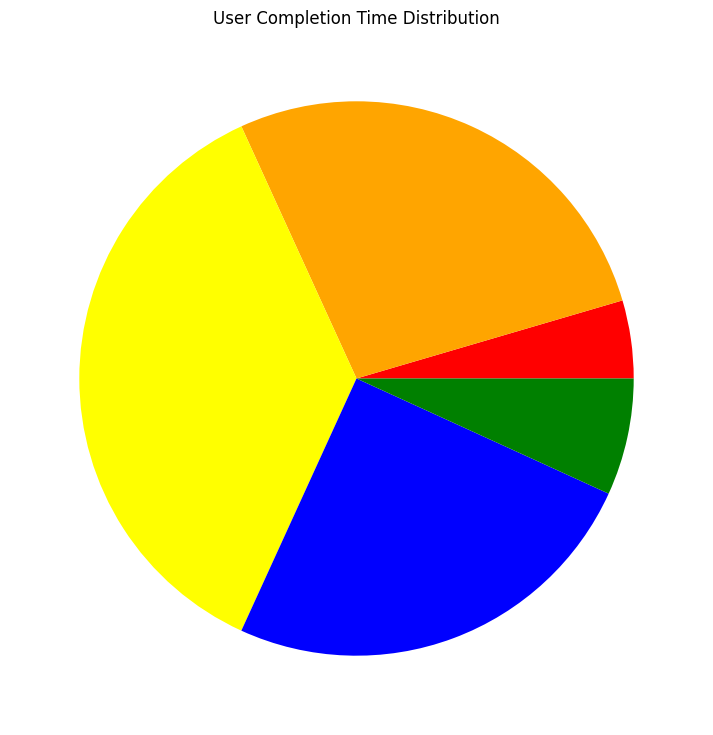

In [6]:
compute_time_records = {}

for player_comb in player_collection:
    currGroup = -1
    if player_comb is not None:
        gameRecords = len(player_comb['records'])
        currCompletionTime = player_comb['records'][gameRecords - 1]['timeOrReason']
        currCompletionTimeInt = int(currCompletionTime[:currCompletionTime.find('s')])
        
        if currCompletionTimeInt > 0 and currCompletionTimeInt < 25:
           # 1-24s
           currCandidate = 1
        elif currCompletionTimeInt >= 25 and currCompletionTimeInt < 49:
           # 25-48s
           currCandidate = 2
        elif currCompletionTimeInt >= 49 and currCompletionTimeInt < 73:
           # 49-72s
           currCandidate = 3
        elif currCompletionTimeInt >= 73 and currCompletionTimeInt < 97:
           # 73-96s
           currCandidate = 4 
        else:
           # 97-120s
           currCandidate = 5
 
        if compute_time_records.get(currCandidate) is None:
           compute_time_records[currCandidate] = 0
        
        compute_time_records[currCandidate] += 1

compute_time_records_sorted = sorted(compute_time_records.items(), key=lambda x: x[0])
time_records = [int(time_record[1]) / len(player_collection) for time_record in compute_time_records_sorted]
time_records_color = ["red", "orange", "yellow", "blue", "green"]
plt.figure(figsize=(9, 9))
plt.pie(time_records, labels=None, colors=time_records_color)
plt.title("User Completion Time Distribution")
plt.show()